<h1 align="center"><strong>Feature Engineering & Preprocessing</strong> for Breast Cancer Wisconsin Dataset</h1>

## Dataset Source

[Kaggle: Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data?resource=download)

# Importing Necessary Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import boxcox

# Visual setup
import warnings

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

# Function to Use

In [ ]:
def visualize_state(X, y, title_prefix):
    print(f"\n{title_prefix} - Summary Stats:")
    display(X.describe().T)

    # Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(X.corr(), cmap="coolwarm", annot=False)
    plt.title(f"{title_prefix} - Correlation Matrix")
    plt.tight_layout()
    plt.show()

    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette=["green", "red"], alpha=0.7
    )
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title(f"{title_prefix} - PCA 2D Projection")
    plt.legend(title="Diagnosis", labels=["Benign", "Malignant"])
    plt.tight_layout()
    plt.show()

def correct_skewness_with_plot(df, skew_threshold=1.0, verbose=True):
    df_corrected = df.copy()

    # First pass
    skewed_feats = df_corrected.skew().sort_values(ascending=False)
    skewed = skewed_feats[skewed_feats > skew_threshold].index

    print(f"Skewed columns are:\n{skewed}")

    for col in skewed:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(df_corrected[col], kde=True, bins=30, color="salmon")
        plt.title(f"Before Skew Correction: {col}")

        # Try correction
        if (df_corrected[col] > 0).all():
            df_corrected[col], _ = boxcox(df_corrected[col])
        else:
            df_corrected[col] = np.log1p(
                df_corrected[col] - df_corrected[col].min() + 1
            )

        plt.subplot(1, 2, 2)
        sns.histplot(df_corrected[col], kde=True, bins=30, color="skyblue")
        plt.title(f"After Skew Correction: {col}")
        plt.tight_layout()
        plt.show()
        
    return df_corrected

def clip_outliers_iqr(df, features=None, lower_quantile=0.05, upper_quantile=0.95):
    """
    Clips outliers to specified quantile thresholds using IQR.

    Parameters:
    - df: pandas DataFrame
    - features: list of features to clip (default: all numeric columns)
    - lower_quantile: lower bound quantile
    - upper_quantile: upper bound quantile

    Returns:
    - df_clipped: DataFrame with clipped values
    """
    df_clipped = df.copy()
    if features is None:
        features = df.select_dtypes(include="number").columns.tolist()

    for col in features:
        lower_bound = df[col].quantile(lower_quantile)
        upper_bound = df[col].quantile(upper_quantile)
        df_clipped[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

    print(
        f"Outliers clipped to range between {lower_quantile} and {upper_quantile} quantiles."
    )
    return df_clipped

# Read the Data

In [5]:
# load data
df = pd.read_csv("../data/data.csv")

df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


# Remove Unnecesaary Columns and Prepare the Target Value

In [6]:
# drop ID column
df.drop(columns=["id", "Unnamed: 32"], inplace=True)

df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [7]:
# encode target
df["diagnosis"] = df["diagnosis"].map({"M": 1, "B": 0})

df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [9]:
# separate features and target
X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

X

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400



Step 1: Raw Data - Summary Stats:


,count,mean,std,min,25%,50%,75%,max
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
fractal_dimension_mean,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


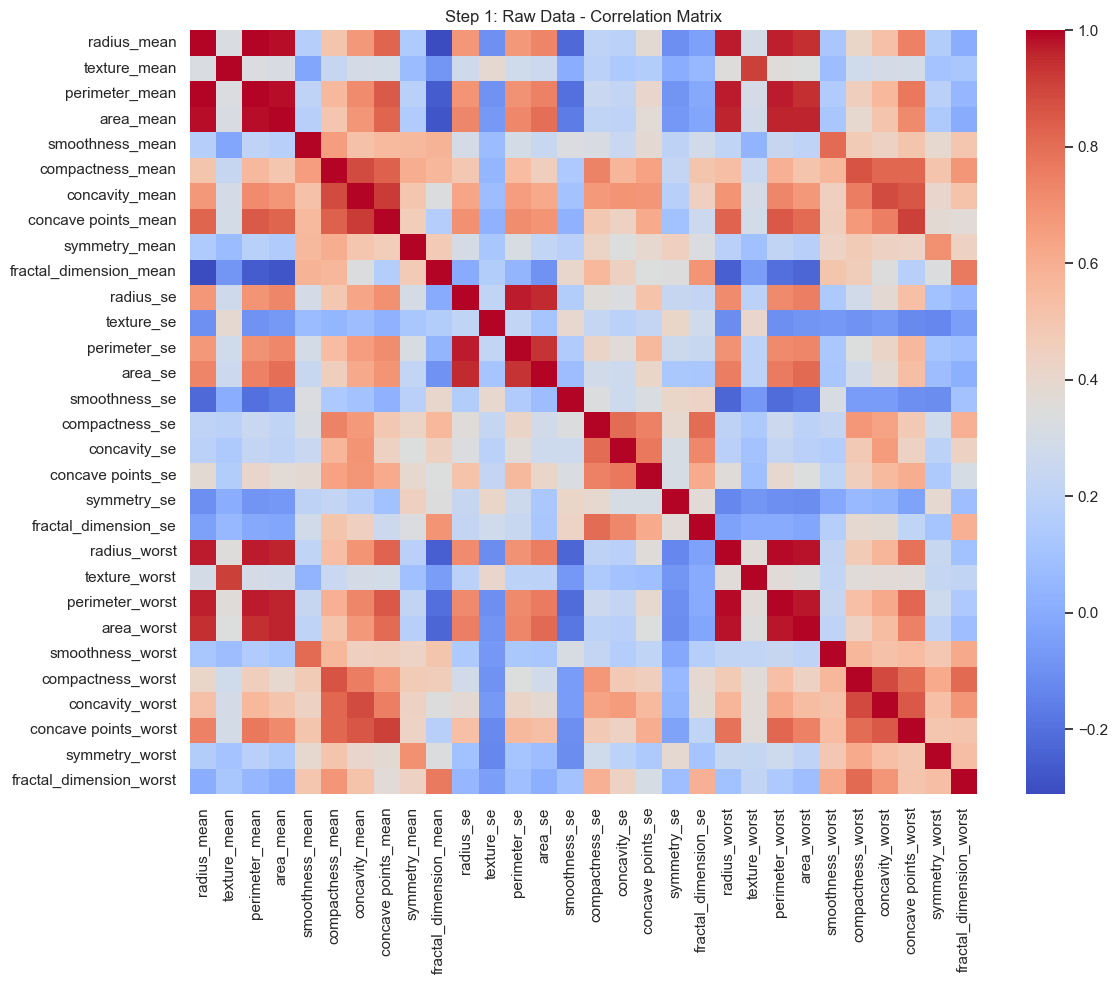

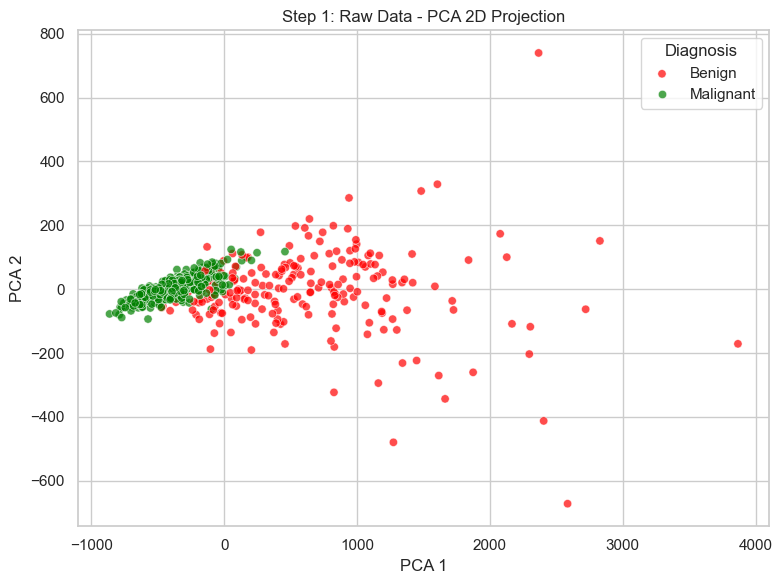

In [10]:
visualize_state(X, y, title_prefix="Step 1: Raw Data")

# Clip Outliers

Outliers clipped to range between 0.03 and 0.97 quantiles.

Step 2: After Outlier Clipping - Summary Stats:


,count,mean,std,min,25%,50%,75%,max
radius_mean,569.0,14.072421,3.286778,9.029520,11.700000,13.370000,15.780000,21.552400
texture_mean,569.0,19.250219,4.021719,12.711200,16.170000,18.840000,21.800000,28.209600
perimeter_mean,569.0,91.585171,22.494982,58.798800,75.170000,86.240000,104.100000,142.988000
area_mean,569.0,644.257800,312.314103,246.396000,420.300000,551.100000,782.700000,1418.520000
smoothness_mean,569.0,0.096242,0.012950,0.073512,0.086370,0.095870,0.105300,0.123696
compactness_mean,569.0,0.103341,0.049075,0.037663,0.064920,0.092630,0.130400,0.227452
concavity_mean,569.0,0.087114,0.074233,0.001489,0.029560,0.061540,0.130700,0.286856
concave points_mean,569.0,0.048459,0.037077,0.003130,0.020310,0.033500,0.074000,0.146664
symmetry_mean,569.0,0.180800,0.025148,0.137308,0.161900,0.179200,0.195700,0.239796
fractal_dimension_mean,569.0,0.062630,0.006307,0.053072,0.057700,0.061540,0.066120,0.078173


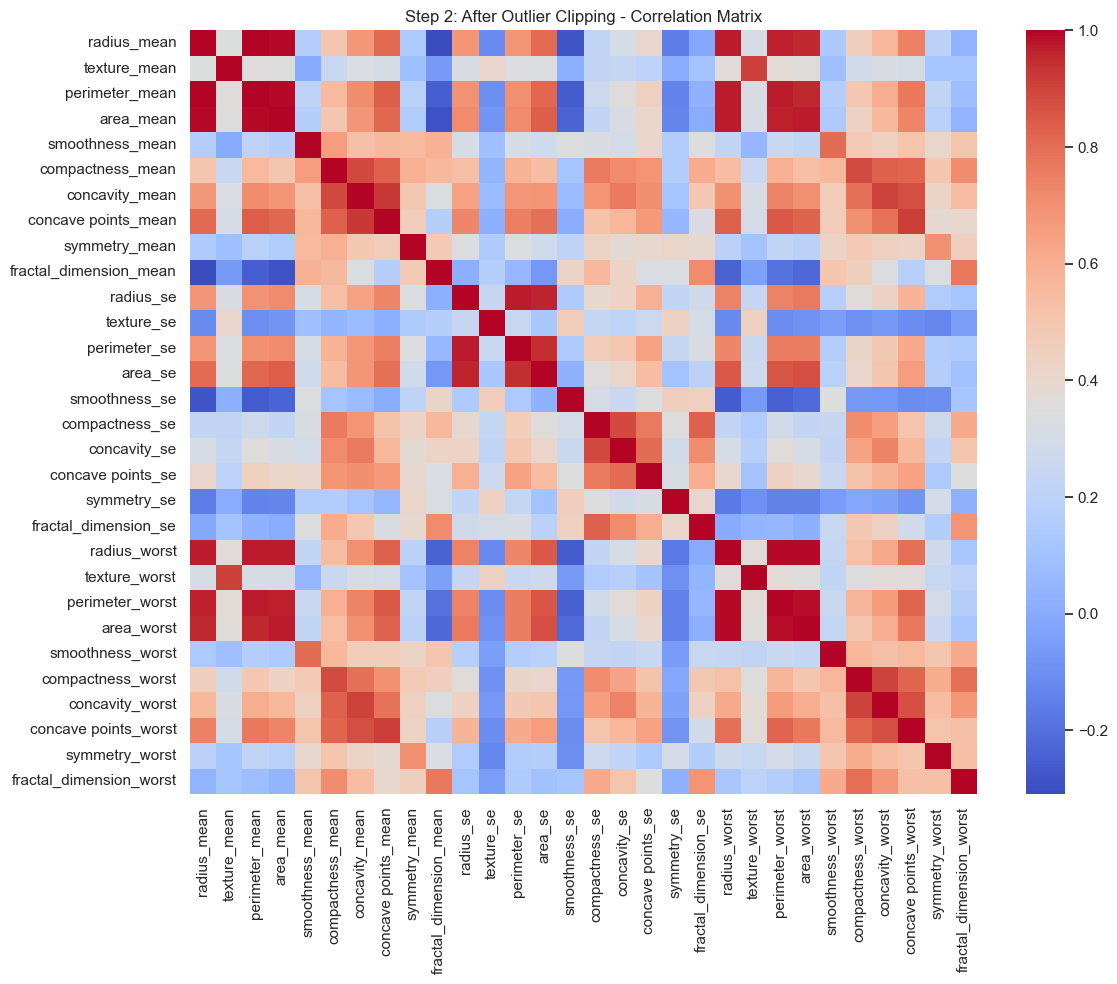

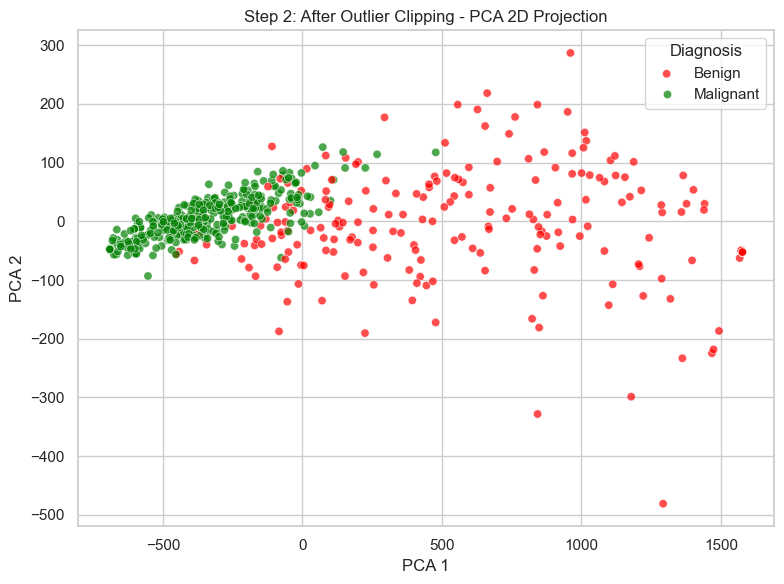

In [11]:
X_clipped = clip_outliers_iqr(X, lower_quantile=0.03, upper_quantile=0.97)

visualize_state(X_clipped, y, title_prefix="Step 2: After Outlier Clipping")

# Correct Skewness

Skewed columns are:
Index(['area_se', 'perimeter_se', 'radius_se', 'fractal_dimension_se',
       'area_worst', 'compactness_se', 'symmetry_se', 'concavity_se',
       'concavity_mean', 'area_mean', 'smoothness_se'],
      dtype='object')


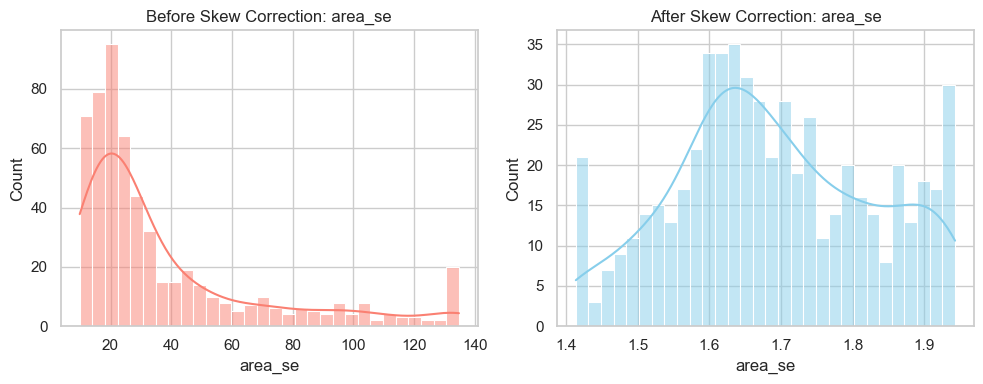

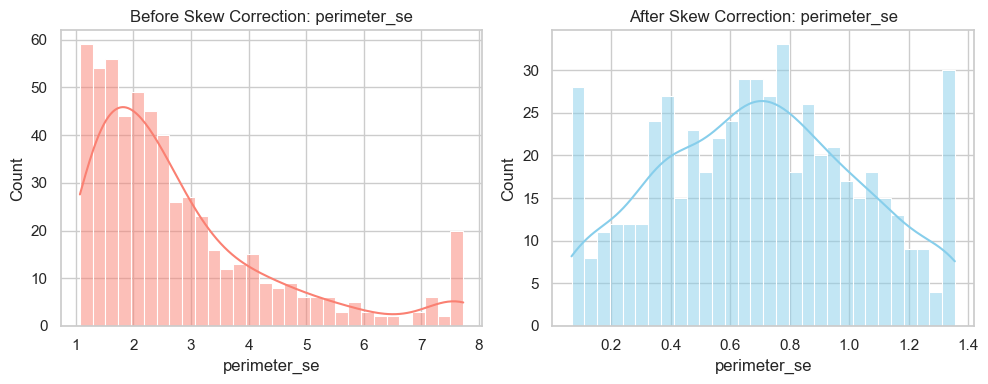

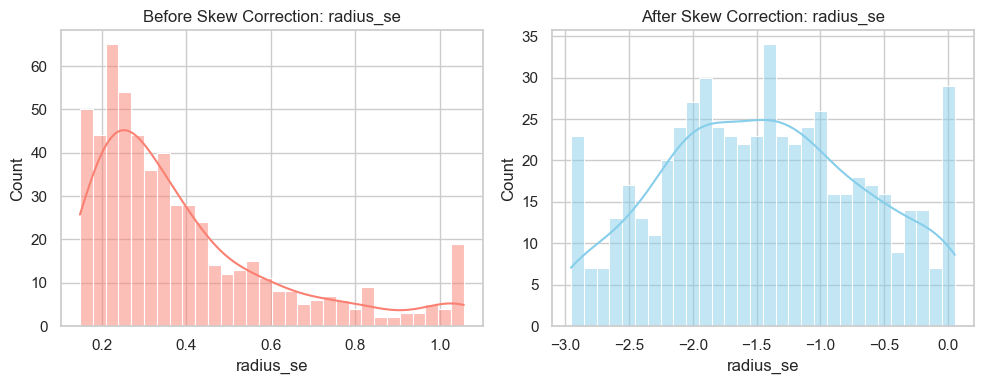

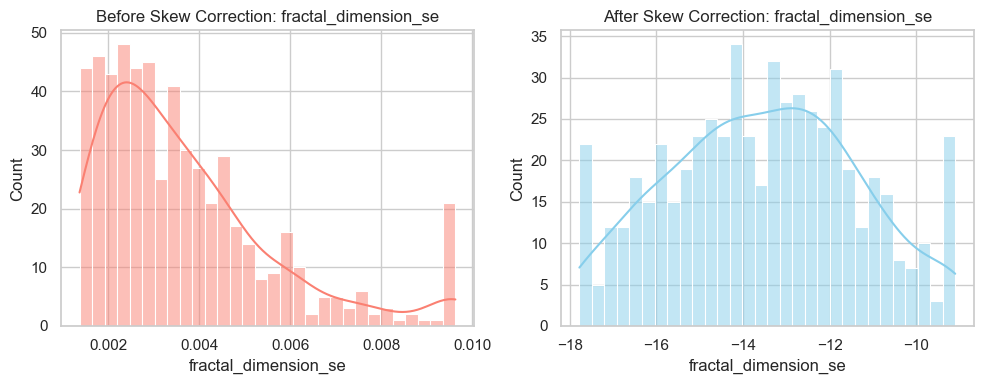

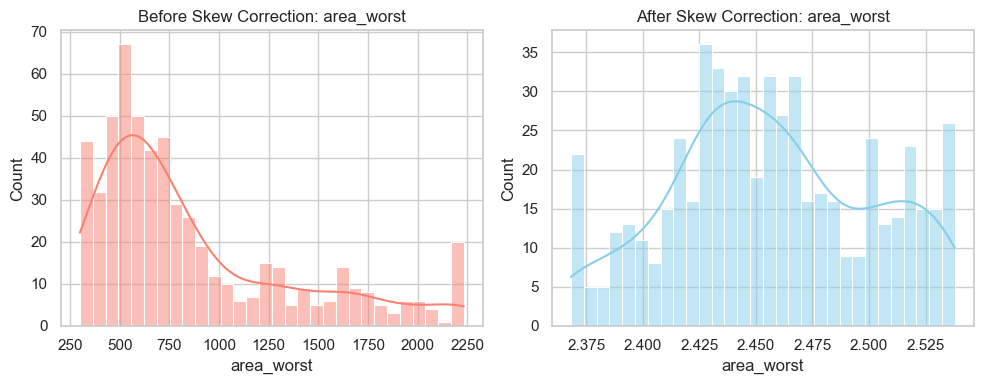

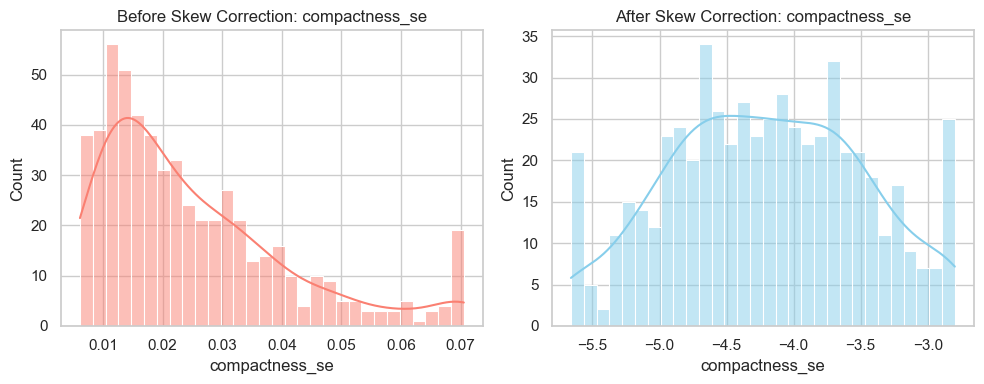

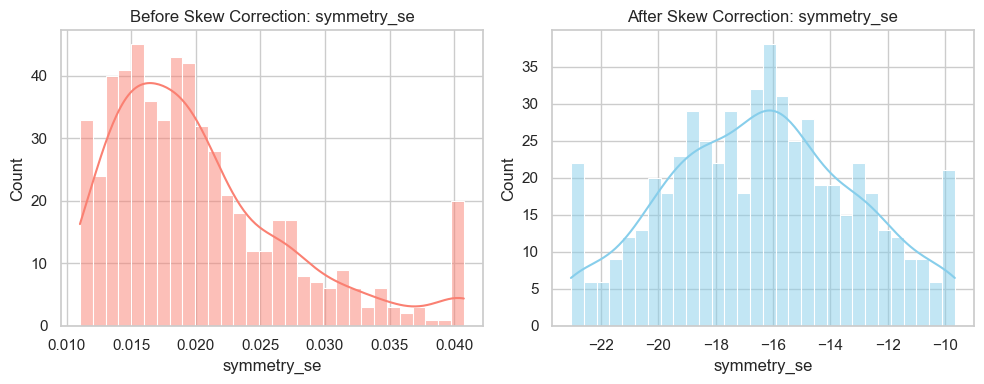

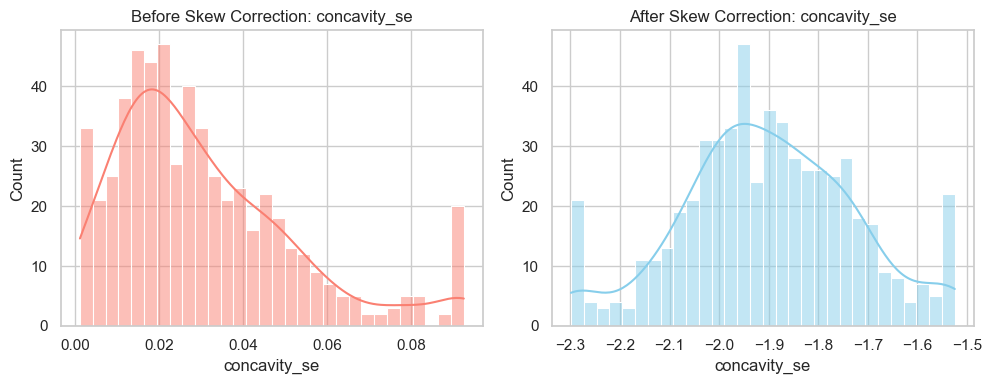

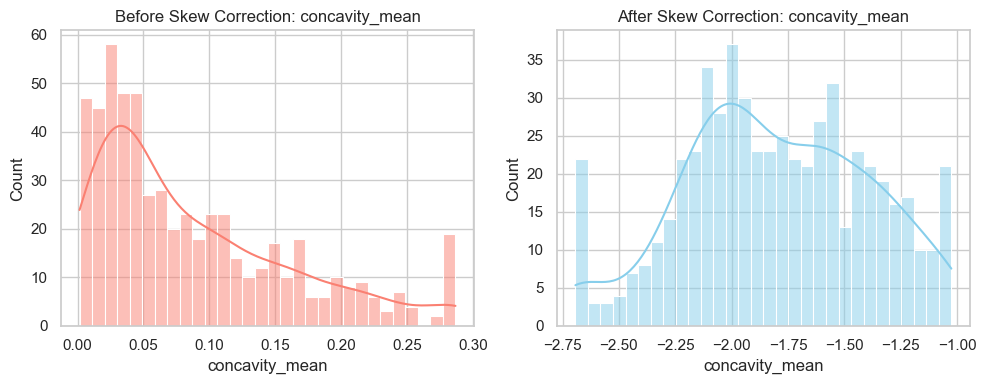

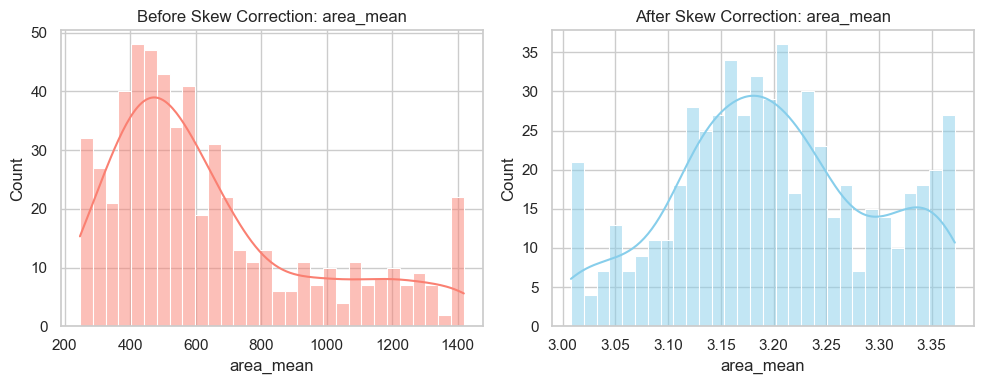

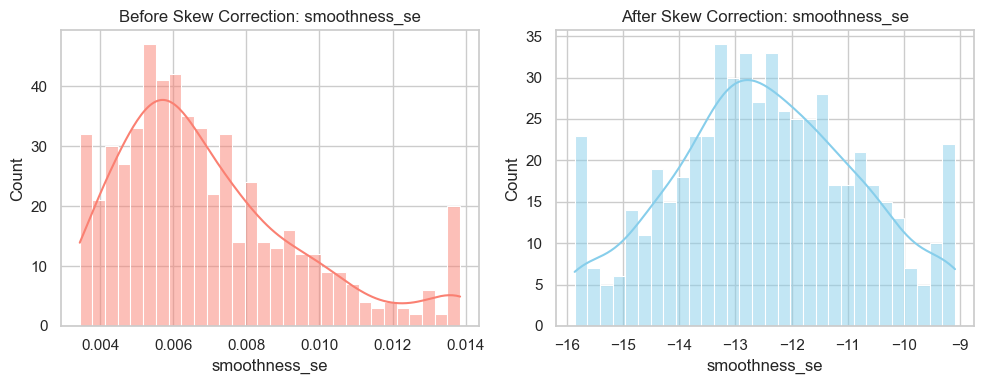

In [12]:
X_skew_corrected = correct_skewness_with_plot(X_clipped)
#X_skew_corrected = correct_skewness_with_plot(X)

In [ ]:
# verify theres no skewness anymore
X_skew_corrected = correct_skewness_with_plot(X_skew_corrected)

Skewed columns are:
Index([], dtype='object')



Step 3: After Skewness Correction - Summary Stats:


,count,mean,std,min,25%,50%,75%,max
radius_mean,569.0,14.072421,3.286778,9.029520,11.700000,13.370000,15.780000,21.552400
texture_mean,569.0,19.250219,4.021719,12.711200,16.170000,18.840000,21.800000,28.209600
perimeter_mean,569.0,91.585171,22.494982,58.798800,75.170000,86.240000,104.100000,142.988000
area_mean,569.0,3.199753,0.094336,3.007852,3.136023,3.194860,3.265416,3.371869
smoothness_mean,569.0,0.096242,0.012950,0.073512,0.086370,0.095870,0.105300,0.123696
compactness_mean,569.0,0.103341,0.049075,0.037663,0.064920,0.092630,0.130400,0.227452
concavity_mean,569.0,-1.804934,0.410352,-2.692850,-2.090552,-1.828744,-1.485722,-1.025106
concave points_mean,569.0,0.048459,0.037077,0.003130,0.020310,0.033500,0.074000,0.146664
symmetry_mean,569.0,0.180800,0.025148,0.137308,0.161900,0.179200,0.195700,0.239796
fractal_dimension_mean,569.0,0.062630,0.006307,0.053072,0.057700,0.061540,0.066120,0.078173


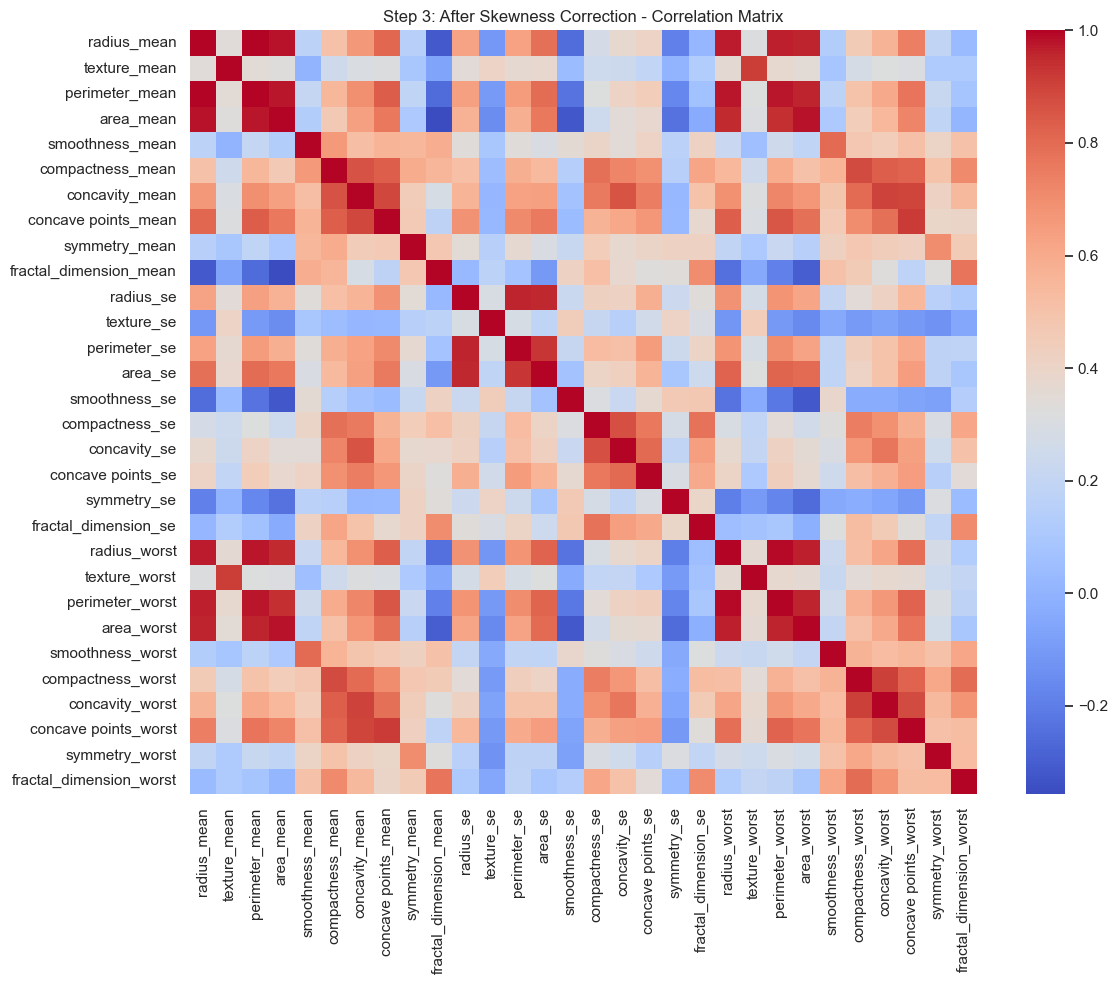

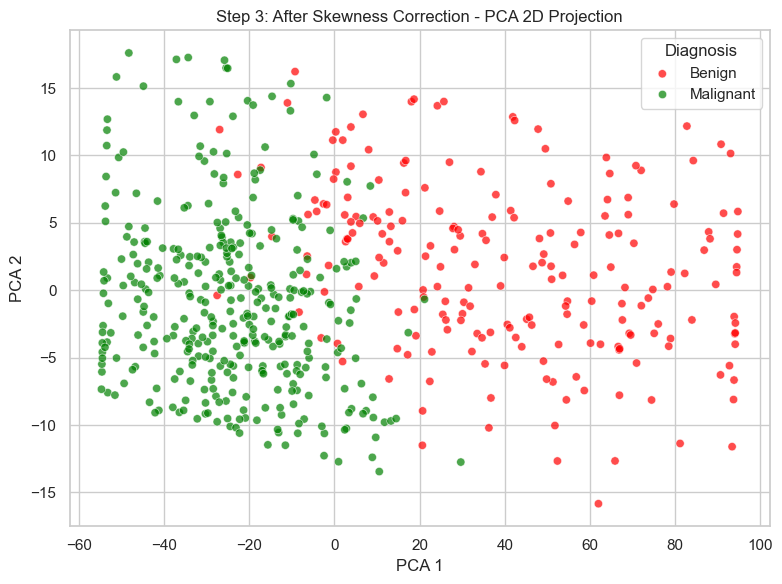

In [14]:
visualize_state(X_skew_corrected, y, title_prefix="Step 3: After Skewness Correction")

# Standard Scaling


Step 4: After Scaling - Summary Stats:


,count,mean,std,min,25%,50%,75%,max
radius_mean,569.0,-2.747265e-16,1.00088,-1.535649,-0.722443,-0.213899,0.519987,2.277781
texture_mean,569.0,-4.370650e-17,1.00088,-1.627357,-0.766570,-0.102091,0.634561,2.229710
perimeter_mean,569.0,-5.744282e-16,1.00088,-1.458780,-0.730368,-0.237825,0.556828,2.287090
area_mean,569.0,2.460051e-15,1.00088,-2.036013,-0.676159,-0.051917,0.696659,1.826094
smoothness_mean,569.0,1.248757e-17,1.00088,-1.756758,-0.762978,-0.028757,0.700054,2.121815
compactness_mean,569.0,-1.623384e-16,1.00088,-1.339492,-0.783593,-0.218452,0.551862,2.531223
concavity_mean,569.0,4.745277e-16,1.00088,-2.165692,-0.696642,-0.058074,0.778582,1.902060
concave points_mean,569.0,-3.746271e-17,1.00088,-1.223626,-0.759874,-0.403818,0.689456,2.650977
symmetry_mean,569.0,-2.747265e-16,1.00088,-1.730986,-0.752217,-0.063672,0.593033,2.348067
fractal_dimension_mean,569.0,-3.059455e-16,1.00088,-1.516760,-0.782344,-0.172923,0.553938,2.466757


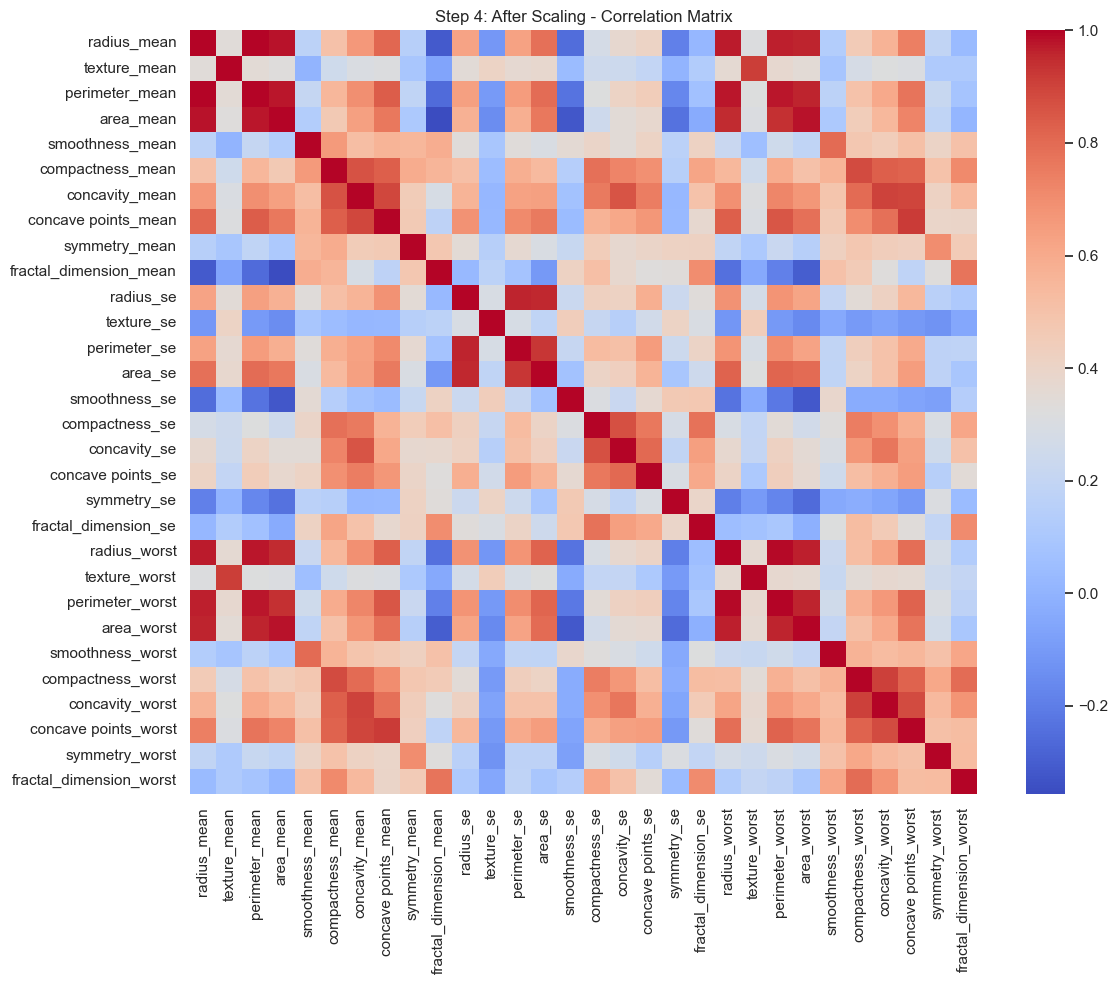

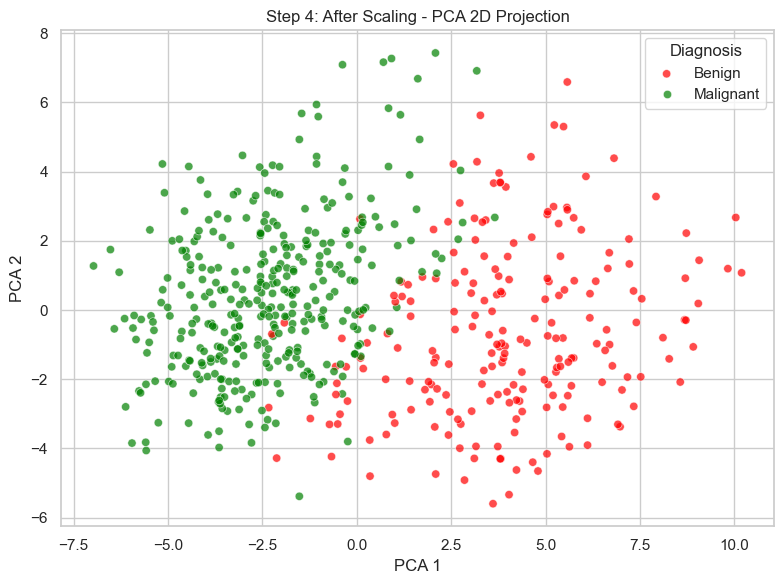

In [16]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_skew_corrected), columns=X_skew_corrected.columns)

visualize_state(X_scaled, y, title_prefix="Step 4: After Scaling")

# Final Save

In [17]:
preprocessed_df = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)
preprocessed_df.to_csv("../data/preprocessed_data.csv", index=False)
print("Preprocessing complete. Saved to 'data/preprocessed_data.csv'.")

Preprocessing complete. Saved to 'data/preprocessed_data.csv'.
